In [ ]:
!pip install tensorflow

In [3]:

from tensorflow import keras
from tensorflow.keras import layers, models, callbacks



from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.callbacks import EarlyStopping


In [4]:

def string_number(x):
    x = x.lower()
    new = ""
    for each in x :
        new = new + str( ord(each) )
    return new


def char_number(x):    
    return str( ord(x)  )



def getConvertedFormatofText(x):

    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(x.values.astype('U'))
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

    return tfidf_transformer


def getValidationData(xtest, ytest):
    xtest, xvalid, ytest, yvalid = train_test_split(xtest, ytest, test_size=0.50, random_state=42)
    return xtest, xvalid, ytest, yvalid


def getWordSplitData():
    data = pd.read_csv("word_split_encoded.tsv", sep="\t")
    data = data.iloc[0:1000000,]
    data.columns = ["words", "output", "wordlen"]
    #     data = data.dropna()    
    x = data.words.map(char_number)
    x = x.values.astype('int32')
    y = data.output
    y = y.values.astype('int64')
    return y, x


def getWordSplitOHEData():
    data = pd.read_csv("word_splits_ohe.tsv", sep="\t")
#     data = data.dropna()
    l = [x for x in range(2, data.shape[1])]
    x = data.iloc[:,l]
    x = x.values.astype('int16')
    y = data.output
    y = y.values.astype('int64')
    return x, y


def getTrainTestData():        
    x, y = getWordSplitData()
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.40, random_state = 42)
    xtest, xvalid, ytest, yvalid = getValidationData(xtest, ytest)
    return  xtrain, xtest, xvalid, ytrain, ytest, yvalid






In [5]:


def getTheNetwork(num=6):
    i = 0
    list_dense = []    
    list_dense.append(layers.Dense(units= 100 * (num) , activation='relu', input_dim=1))
#     list_dense.append(layers.Dropout(0.3))
    for x in range(2,num):
        i = i+1
        list_dense.append(layers.Dense(units= 100 * ((num)-i), activation='relu' ))        
#         list_dense.append(layers.Dropout(0.3))
        
    
    list_dense.append(layers.Dense(units= 100, activation='relu' ))
    list_dense.append(layers.Dense(units=1))

    return  list_dense


In [14]:
model = keras.Sequential(getTheNetwork(6))

In [15]:


model.compile(optimizer='adam', loss = 'huber', metrics=['mse', 'mae', 'mape'])


early_stopping = EarlyStopping(
    min_delta=0.01,
    patience=40,
    restore_best_weights=True
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 600)               1200      
_________________________________________________________________
dense_8 (Dense)              (None, 500)               300500    
_________________________________________________________________
dense_9 (Dense)              (None, 400)               200400    
_________________________________________________________________
dense_10 (Dense)             (None, 300)               120300    
_________________________________________________________________
dense_11 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [16]:
xtrain, xtest, xvalid, ytrain, ytest, yvalid = getTrainTestData()



In [23]:
xtrain[0:5], ytrain[0:5]

(array([1011100000000001, 1010105000000001, 1000000011700001,
        1000001010800001, 1000011500000001]),
 array([102, 110, 106, 114, 104], dtype=int32))

In [17]:
export_path_keras = "simple_file_hacker_100.h5"
save_checkpoint = keras.callbacks.ModelCheckpoint(
    export_path_keras, monitor='loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch'
)

In [ ]:
#char counts train data

history = model.fit(
    xtrain, ytrain,
    validation_data=(xvalid, yvalid),
    batch_size=100,
    epochs=100,
    callbacks=[early_stopping, save_checkpoint],
    verbose=1
)

# export_path_keras = "simple_file_hacker.h5"
# model.save(export_path_keras)


In [ ]:
#ohe data trained

history = model.fit(
    xtrain, ytrain,
    validation_data=(xvalid, yvalid),
    batch_size=50,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

export_path_keras = "simple_file_hacker_ohe.h5"
model.save(export_path_keras)


In [4]:
model = models.load_model('simple_file_hacker.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              2000      
_________________________________________________________________
dense_1 (Dense)              (None, 900)               900900    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               720800    
_________________________________________________________________
dense_3 (Dense)              (None, 700)               560700    
_________________________________________________________________
dense_4 (Dense)              (None, 600)               420600    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               300500    
_________________________________________________________________
dense_6 (Dense)              (None, 400)               2

In [ ]:
#char counts
history = model.fit(
    xtrain, ytrain,
    validation_data=(xvalid, yvalid),
    batch_size=100,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

export_path_keras = "simple_file_hacker.h5"
model.save(export_path_keras)

In [9]:
ypred = model.predict(xtest)

mean_absolute_error(ytest, ypred)

8.57765388379088

In [10]:
xtest[0:5], ypred[0:5], ytest[0:5]

(array([1101070000000001, 1000000000011701, 1001010500000001,
        1110000000020001, 1000001000170001]),
 array([[106.939255],
        [106.939255],
        [106.939255],
        [106.939255],
        [106.939255]], dtype=float32),
 array([109, 108, 111,  55, 101], dtype=int32))

In [ ]:
model.load_weights('simple_file_hacker_ohe.h5')

In [7]:
model.load_weights('simple_file_hacker_ohe_v2_01.h5')

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3700      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               30300     
_________________________________________________________________
dense_2 (Dense)              (None, 400)               120400    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               200500    
_________________________________________________________________
dense_4 (Dense)              (None, 600)               300600    
_________________________________________________________________
dense_5 (Dense)              (None, 700)               420700    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 7

In [ ]:
#char counts
history = model.fit(
    xtrain, ytrain,
    validation_data=(xvalid, yvalid),
    batch_size=100,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

export_path_keras = "simple_file_hacker.h5"
model.save(export_path_keras)

In [ ]:
#ohe
history = model.fit(
    xtrain, ytrain,
    validation_data=(xvalid, yvalid),
    batch_size=50,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

export_path_keras = "simple_file_hacker_ohe_v2_01.h5"
model.save(export_path_keras)

In [9]:

ypred = model.predict(xtest)

In [15]:
ypred = model.predict([[1000000011200001]])

ypred

array([[106.773796]], dtype=float32)

In [19]:
ypred = model.predict([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

# pd.get_dummies("a", prefix='char')

In [20]:
# ypred.values.astype('int64')
ypred = pd.Series([ypred])
ypred.values.astype('int64')

ypred

0    [[1000466000000000.0]]
dtype: object

In [13]:
ypred.shape

(1064260, 1)

In [ ]:
ypred = ypred.reshape(1064260, 1)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(ytest,ypred))
print(confusion_matrix(ytest,ypred))

In [ ]:
# Evaluate the model
loss, acc = model.evaluate(xtest, ytest, verbose=2)
print("model, accuracy: {:5.2f}%".format(100 * acc))

In [12]:
mean_absolute_error(ytest, ypred)

8.548263428280345

In [ ]:



import matplotlib.pyplot as plt


plt.plot(xtrain,ytrain, color ='r',label = 'Trained data')

plt.ylabel('Y axis')
plt.xlabel('X axis')
plt.legend()

plt.show()


plt.plot(xtest,ytest, color ='r',label = 'Test data')


plt.ylabel('Y axis')
plt.xlabel('X axis')
plt.legend()

plt.show()



plt.plot(xtest,ypred, color ='g',label = 'Predicted data')


plt.ylabel('Y axis')
plt.xlabel('X axis')
plt.legend()

plt.show()



8.557379722595215
8.557379722595215


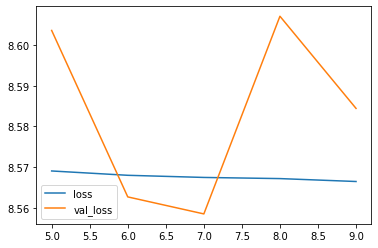

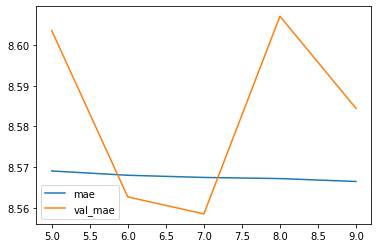

In [17]:

history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['mae', 'val_mae']].plot()

print(history_df['val_loss'].min())
print(history_df['val_mae'].min())

In [ ]:
#convert a word to single char cell

def writeRow(char, enc, wlen):
     with open("word_split_encoded.tsv", 'a') as decodeMsgWritter:
        decodeMsgWritter.write("\n{0}\t{1}\t{2}".format(char,enc,wlen))


def convertDatato_chars_encryption(x):
    row_x = x.words; row_y = x.output;
    row_x = list(row_x.lower())
    for each in range(16,len(row_y)+16,16):
        if each-16 == 0:
            writeRow(row_x[int(each/16)-1],row_y[each-16:each], len(row_x) )            
        else:
            writeRow(row_x[int(each/16)-1],row_y[each-16:each], 0 )

    
    
    
data = pd.read_csv("title_simple_encoded.tsv", sep="\t")
data.columns=["words","output"]
data = data.dropna()


data.apply(convertDatato_chars_encryption, axis = 1)
print('completed')

In [8]:

import pandas as pd

data = pd.read_csv("word_splits_ohe.tsv", sep="\t")
data.head(1)


,output,wordlen,char_0,char_1,char_2,char_3,char_4,char_5,char_6,char_7,...,char_q,char_r,char_s,char_t,char_u,char_v,char_w,char_x,char_y,char_z
0,1000000101050001,6,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
#one hot encoder 


from sklearn.preprocessing import OneHotEncoder as ohe


ohei = ohe(handle_unknown='ignore', sparse=False)

reshaped_char_data = data.loc[:,["char"]].values.reshape(-1, 1)

transformData = pd.DataFrame(ohei.fit_transform(reshaped_char_data))


# transformData.index = data.index

transformData.head(20)





In [ ]:
pd.get_dummies(df['country'], prefix='country')

transformData.describe()

In [ ]:


# pd.get_dummies(data["char"], prefix='char')


data = pd.concat([data ,pd.get_dummies(data['char'], prefix='char')],axis=1)
data.drop(['char'], axis=1, inplace=True)

In [ ]:
data.to_csv("word_splits_ohe.tsv", sep="\t", index=False)

In [ ]:


data.dtypes



In [ ]:
!pip install sklearn

In [ ]:
from sklearn.preprocessing import 